### Experiment 2 - Table 2

Calculating test accuracy and robustness (adversarial accuracy, adv. acc) for different datasets and different settings, given Trimmed mean and median aggregation schemes

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd
import gc

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
# from utils.util_notebooks import *
from utils.util_notebooks import set_args, import_model_weights, get_adv_acc
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

def calc_atk_model(model_inject, model_global, keys, weight_scale, weight_scale_2):

    atk_model = copy.deepcopy(model_inject)
    inject_state_dict = model_inject.state_dict(keep_vars=False)
    global_state_dict = model_global.state_dict(keep_vars=False)
    return_state_dict = atk_model.state_dict(keep_vars=False)
    total_weight = weight_scale * weight_scale_2

    for key in keys:
    # for key in inject_state_dict.keys():
        # print(key, "total")
        diff = inject_state_dict[key].data.clone() - global_state_dict[key].data.clone()
        return_state_dict[key].data = total_weight * diff + global_state_dict[key].data.clone()

    atk_model.load_state_dict(return_state_dict)

    return atk_model

def undo_calc_atk_model(atk_model, model_global, keys, weight_scale, weight_scale_2):
    """
    Reverses the `calc_atk_model` process to find `model_inject` from `atk_model` and `model_global`.
    
    Args:
        atk_model (torch.nn.Module): The attacker model generated from `calc_atk_model`.
        model_global (torch.nn.Module): The global model used in `calc_atk_model`.
        keys (list of str): The keys of the state dictionary to process.
        weight_scale (float): Weight scale factor used in `calc_atk_model`.
        weight_scale_2 (float): Second weight scale factor used in `calc_atk_model`.
    
    Returns:
        torch.nn.Module: The reconstructed `model_inject`.
    """
    model_inject = copy.deepcopy(model_global)
    atk_state_dict = atk_model.state_dict(keep_vars=False)
    global_state_dict = model_global.state_dict(keep_vars=False)
    inject_state_dict = model_inject.state_dict(keep_vars=False)
    total_weight = weight_scale * weight_scale_2

    for key in keys:
        # Reverse the operation to calculate the original inject_state_dict
        diff = (atk_state_dict[key].data.clone() - global_state_dict[key].data.clone()) / total_weight
        inject_state_dict[key].data = diff + global_state_dict[key].data.clone()

    model_inject.load_state_dict(inject_state_dict)

    return model_inject

# Clone data from attack model to client model
def clone_model_weights(model_source, model_target, keys):
    target_state_dict = model_target.state_dict(keep_vars=True)
    source_state_dict = model_source.state_dict(keep_vars=True)
    
    for key in keys:
        target_state_dict[key].data = source_state_dict[key].data.clone()

    return

# Expand aggregator.mix() function
def UNL_mix(aggregator, adv_id, model_inject, keys, weight_scale_2, dump_flag=False, aggregation_op = None, tm_beta = 0.05, median_threshold = None):
    weight_scale = 1/aggregator.clients_weights
    model_global = aggregator.global_learners_ensemble[0].model

    # if aggregation_op == None:
    #     aggregation_op = aggregator.aggregation_op
        
    # Based on aggregation methods change weight scale
    if aggregation_op in ['median', 'krum', 'median_sublayers']:# == "median" or aggregation_op == "krum":
        weight_scale = np.ones(weight_scale.shape)

    if aggregation_op in ['trimmed_mean']: # simple averaging takes place instead of weighted
        N_removed = int(tm_beta*len(aggregator.clients))
        weight_scale = np.ones(len(aggregator.clients))  * (len(aggregator.clients)-N_removed*2)
        print("trimmed mean, N removed: ", N_removed)
        print("weight scale: \n", weight_scale)

    # Give adversarial clients boosted models and train regular clients 1 round
    benign_id = list(range(len(aggregator.clients)))

    for a_id in adv_id:
        benign_id.remove(a_id)
        temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)
        aggregator.clients[a_id].learners_ensemble[0].model.cpu()
        del aggregator.clients[a_id].learners_ensemble[0].model
        aggregator.clients[a_id].learners_ensemble[0].model = temp_atk_model.cuda()
        del temp_atk_model
        gc.collect()
        torch.cuda.empty_cache()

    for c_id in benign_id:
        aggregator.clients[c_id].step()

    # Aggregate model and download
    for learner_id, learner in enumerate(aggregator.global_learners_ensemble):
        learners = [client.learners_ensemble[learner_id] for client in aggregator.clients]
        if aggregation_op is None:
            average_learners(learners, learner, weights=aggregator.clients_weights)
        elif aggregation_op == 'median':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'median_sublayers':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_median_sublayers.pkl") 
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_median_with_threshold(
                learners, 
                learner, 
                threshold = median_threshold,
                dump_path=dump_path
            )
        elif aggregation_op == 'trimmed_mean':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_tm.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_tm(
                learners, 
                learner, 
                beta=tm_beta, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum(
                learners, 
                learner, 
                dump_path=dump_path
            )
        elif aggregation_op == 'krum_modelwise':
            dump_path = (
                os.path.join(aggregator.dump_path, f"round{aggregator.c_round}_krum_modelwise.pkl")
                if dump_flag
                else None
            )
            byzantine_robust_aggregate_krum_modelwise(
                1,
                learners,
                learner,
                dump_path=dump_path
            )
        else:
            raise NotImplementedError


    # assign the updated model to all clients
    aggregator.update_clients()

    aggregator.c_round += 1

    return 

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 40
exp = "cifar10"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/231031_FAT150round/FAT/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/230922_baseline_train/fedavg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 94.95it/s] 


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:18<00:00,  2.20it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [5]:
aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
aggregation_op = 'trimmed_mean'
aggregator.op = aggregation_op
weight_scale_2 = 1
atk_rounds = 1
tm_beta = 0
adv_id = [0]

model_inject = model_Fedavg
keys = desired_keys

################################# Code starts here

weight_scale = 1/aggregator.clients_weights
model_global = aggregator.global_learners_ensemble[0].model

# if aggregation_op == None:
#     aggregation_op = aggregator.aggregation_op
    
# Based on aggregation methods change weight scale
if aggregation_op in ['median', 'krum', 'median_sublayers']:# == "median" or aggregation_op == "krum":
    weight_scale = np.ones(weight_scale.shape)

if aggregation_op in ['trimmed_mean']: # simple averaging takes place instead of weighted
    N_removed = int(tm_beta*len(aggregator.clients))
    weight_scale = np.ones(len(aggregator.clients))  * (len(aggregator.clients)-N_removed*2)
    print("trimmed mean, N removed: ", N_removed)
    print("weight scale: \n", weight_scale)

# Give adversarial clients boosted models and train regular clients 1 round
benign_id = list(range(len(aggregator.clients)))

for a_id in adv_id:
    benign_id.remove(a_id)
    temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)

for c_id in benign_id:
    aggregator.clients[c_id].step()

learner_id = 0
global_learner = aggregator.global_learners_ensemble[learner_id]
learners =  [client.learners_ensemble[learner_id] for client in [aggregator.clients[i] for i in benign_id]]
adjusted_weights = aggregator.clients_weights[benign_id] / torch.sum(aggregator.clients_weights[benign_id])
average_learners(learners, global_learner, weights=adjusted_weights)

model_global_updated = aggregator.global_learners_ensemble[0].model

############# - Unmix temp atk model - ###########
reverse_model = undo_calc_atk_model(temp_atk_model, model_global_updated, keys, weight_scale[a_id], weight_scale_2)


trimmed mean, N removed:  0
weight scale: 
 [40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00]


/home/ubuntu/fedatk_unl_tj/learners/learner.py:192: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


In [ ]:
# aggregator.load_state(dir_path=save_path_FAT)
# aggregator.update_clients()
# aggregation_op = 'trimmed_mean'
# aggregator.op = aggregation_op
# weight_scale_2 = 1
# atk_rounds = 1
# tm_beta = 0
# adv_id = [0]

# model_inject = model_Fedavg
# keys = desired_keys

# ################################# Code starts here

# weight_scale = 1/aggregator.clients_weights
# model_global = aggregator.global_learners_ensemble[0].model

# # if aggregation_op == None:
# #     aggregation_op = aggregator.aggregation_op
    
# # Based on aggregation methods change weight scale
# if aggregation_op in ['median', 'krum', 'median_sublayers']:# == "median" or aggregation_op == "krum":
#     weight_scale = np.ones(weight_scale.shape)

# if aggregation_op in ['trimmed_mean']: # simple averaging takes place instead of weighted
#     N_removed = int(tm_beta*len(aggregator.clients))
#     weight_scale = np.ones(len(aggregator.clients))  * (len(aggregator.clients)-N_removed*2)
#     print("trimmed mean, N removed: ", N_removed)
#     print("weight scale: \n", weight_scale)

# # Give adversarial clients boosted models and train regular clients 1 round
# benign_id = list(range(len(aggregator.clients)))

# for a_id in adv_id:
#     benign_id.remove(a_id)
#     temp_atk_model = calc_atk_model(model_inject, model_global, keys, weight_scale[a_id], weight_scale_2)
#     aggregator.clients[a_id].learners_ensemble[0].model.cpu()
#     del aggregator.clients[a_id].learners_ensemble[0].model
#     aggregator.clients[a_id].learners_ensemble[0].model = temp_atk_model.cuda()
    
# # for c_id in benign_id:
# #     aggregator.clients[c_id].step()

# learner_id = 0
# global_learner = aggregator.global_learners_ensemble[learner_id]
# # learners =  [client.learners_ensemble[learner_id] for client  in [aggregator.clients[i] for i in benign_id]]
# learners = [client.learners_ensemble[learner_id] for client in aggregator.clients]
# # adjusted_weights = aggregator.clients_weights[benign_id] / torch.sum(aggregator.clients_weights[benign_id])
# # average_learners(learners, global_learner, weights=adjusted_weights)

# # model_global_updated = aggregator.global_learners_ensemble[0].model

# # ############# - Unmix temp atk model - ###########
# # reverse_model = undo_calc_atk_model(temp_atk_model, model_global_updated, keys, weight_scale[a_id], weight_scale_2)

# target_learner = global_learner
# beta = 0.00
# average_params = True
# average_gradients = False
# weights = weight_scale

# target_state_dict = target_learner.model.state_dict(keep_vars=True)

# param_val = defaultdict(list)
# grad_val = defaultdict(list)

# sort_indices = list()

# for key in target_state_dict:

#     if target_state_dict[key].data.dtype == torch.float32:

#         if average_params:
#             target_state_dict[key].data.fill_(0.)

#         if average_gradients:
#             target_state_dict[key].grad = target_state_dict[key].data.clone()
#             target_state_dict[key].grad.data.fill_(0.)

#         for learner_id, learner in enumerate(learners):
#             state_dict = learner.model.state_dict(keep_vars=True)

#             if average_params:
#                 # target_state_dict[key].data += weights[learner_id] * state_dict[key].data.clone()
#                 param_val[key].append(state_dict[key].data.clone())

#             if average_gradients:
#                 if state_dict[key].grad is not None:
#                     # target_state_dict[key].grad += weights[learner_id] * state_dict[key].grad.clone()
#                     grad_val[key].append(state_dict[key].grad.clone())
#                 elif state_dict[key].requires_grad:
#                     warnings.warn(
#                         "trying to average_gradients before back propagation,"
#                         " you should set `average_gradients=False`."
#                     )

#         N_removed = int(beta*len(learners))
#         if average_params:
#             sorted_params, indices = torch.sort(torch.stack(param_val[key], dim=0), dim=0)
#             if N_removed ==0:
#                 target_state_dict[key].data = torch.mean(sorted_params, dim=0)
#             else:
#                 target_state_dict[key].data = torch.mean(sorted_params[N_removed:-N_removed], dim=0)
#                 removed_indices = torch.cat((indices[:N_removed], indices[-N_removed:]), dim=0)
#                 sort_indices.append((key, removed_indices))
        


In [48]:
def print_state_dict_keys_side_by_side(state_dict1, state_dict2):
    """
    Prints the keys of two state_dicts side by side.
    """
    keys1 = list(state_dict1.keys())
    keys2 = list(state_dict2.keys())
    
    # Find the maximum length to pad properly
    max_len = max(len(keys1), len(keys2))
    keys1 += [""] * (max_len - len(keys1))  # Pad keys1 if it's shorter
    keys2 += [""] * (max_len - len(keys2))  # Pad keys2 if it's shorter
    
    print(f"{'State Dict 1 Keys':<50} {'State Dict 2 Keys'}")
    print("=" * 100)
    for key1, key2 in zip(keys1, keys2):
        print(f"{key1:<50} {key2}")

# Example usage
state_dict1 = reverse_model.state_dict()
state_dict2 = model_FAT.state_dict()

print_state_dict_keys_side_by_side(state_dict1, state_dict2)


State Dict 1 Keys                                  State Dict 2 Keys
features.0.0.weight                                features.0.0.weight
features.0.1.weight                                features.0.1.weight
features.0.1.bias                                  features.0.1.bias
features.0.1.running_mean                          features.0.1.running_mean
features.0.1.running_var                           features.0.1.running_var
features.0.1.num_batches_tracked                   features.0.1.num_batches_tracked
features.1.conv.0.0.weight                         features.1.conv.0.0.weight
features.1.conv.0.1.weight                         features.1.conv.0.1.weight
features.1.conv.0.1.bias                           features.1.conv.0.1.bias
features.1.conv.0.1.running_mean                   features.1.conv.0.1.running_mean
features.1.conv.0.1.running_var                    features.1.conv.0.1.running_var
features.1.conv.0.1.num_batches_tracked            features.1.conv.0.1.num_batches_t

In [55]:
acc, adv_acc = get_adv_acc(aggregator, reverse_model, eps=eps_attack, step_size = step_size, steps = steps)
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

Test acc:  0.10156250023283064  ( 0.06288553044551902 )  adv acc:  0.10156250023283064  ( 0.06288553044551902 ) 


In [48]:
acc, adv_acc = get_adv_acc(aggregator, model_global_updated, eps=eps_attack, step_size = step_size, steps = steps)
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

Test acc:  0.8059375002980232  ( 0.06464974452913326 )  adv acc:  0.4078125011175871  ( 0.10393385667066404 ) 


In [54]:

acc, adv_acc = get_adv_acc(aggregator, updated_model, eps=eps_attack, step_size = step_size, steps = steps)
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

Test acc:  0.8434375002980232  ( 0.0708755231416786 )  adv acc:  0.0062500000931322575  ( 0.008385255040574247 ) 


Layer Name                                            Cosine Similarity
                                                             0.81872618 !!!
features                                                     0.59676164 !!!
features.0                                                   0.95758742 
features.0.0                                                 0.92377800 !!!
features.0.1                                                 0.95138401 
features.0.2                                                 0.95758742 
features.1                                                   0.83784020 !!!
features.1.conv                                              0.83784020 !!!
features.1.conv.0                                            0.96865016 
features.1.conv.0.0                                          0.90567094 !!!
features.1.conv.0.1                                          0.96303368 
features.1.conv.0.2                                          0.96865016 
features.1.conv.1                 

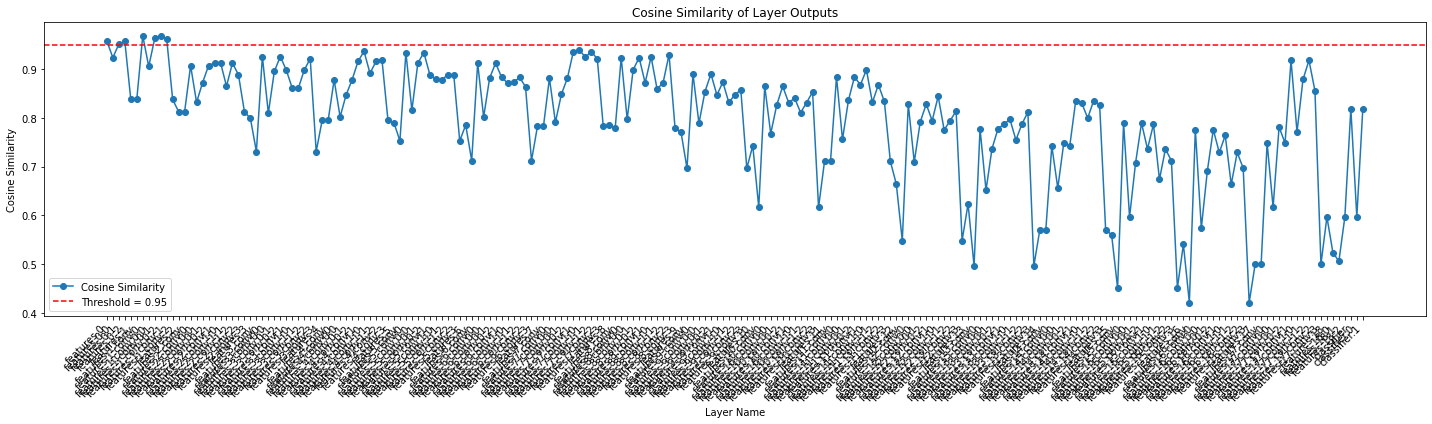

In [52]:
def compare_layer_outputs_with_cosine_similarity(model1, model2, input_data, threshold=0.95):
    """
    Compare outputs of each layer of two models for a given input using cosine similarity.

    Args:
        model1: First model (e.g., reverse_model).
        model2: Second model (e.g., model_Fedavg).
        input_data: Input data in torch.Tensor form.
        threshold: Threshold for cosine similarity to flag significant differences.

    Returns:
        None. Prints results and plots cosine similarity across layers.
    """
    # Ensure models are in evaluation mode
    model1.eval()
    model2.eval()

    # Hook to capture intermediate outputs
    outputs1 = {}
    outputs2 = {}

    def hook_fn1(name):
        def hook(module, input, output):
            outputs1[name] = output.clone().detach().flatten(1)  # Flatten to 2D
        return hook

    def hook_fn2(name):
        def hook(module, input, output):
            outputs2[name] = output.clone().detach().flatten(1)  # Flatten to 2D
        return hook

    # Register hooks for both models
    hooks1 = []
    hooks2 = []
    for name, module in model1.named_modules():
        hooks1.append(module.register_forward_hook(hook_fn1(name)))

    for name, module in model2.named_modules():
        hooks2.append(module.register_forward_hook(hook_fn2(name)))

    # Push input through both models
    with torch.no_grad():
        model1(input_data)
        model2(input_data)

    # Compare layer-by-layer outputs
    print(f"{'Layer Name':<50} {'Cosine Similarity':>20}")
    print("=" * 70)

    layer_names = []
    cosine_similarities = []

    model1_layers = list(model1.named_modules())

    for name1, _ in model1_layers:
        if name1 in outputs1 and name1 in outputs2:
            output1 = outputs1[name1]
            output2 = outputs2[name1]

            # Compute cosine similarity
            cosine_sim = F.cosine_similarity(output1, output2, dim=1).mean().item()
            layer_names.append(name1)
            cosine_similarities.append(cosine_sim)

            # Highlight significant divergence
            flag = "!!!" if cosine_sim < threshold else ""
            print(f"{name1:<50} {cosine_sim:>20.8f} {flag}")

    print(cosine_similarities)

    # Clean up hooks
    for hook in hooks1:
        hook.remove()
    for hook in hooks2:
        hook.remove()

    # Plot cosine similarity across layers
    plt.figure(figsize=(20, 6))
    plt.plot(layer_names[2:], cosine_similarities[2:], marker='o', label='Cosine Similarity')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Layer Name')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity of Layer Outputs')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
dataloader = load_client_data(clients = aggregator.clients, c_id = 0, mode = 'test')
x_data = dataloader.x_data
y_data = dataloader.y_data
# Example usage
_ = compare_layer_outputs_with_cosine_similarity(updated_model, model_FAT, x_data.cuda())
# compare_layer_outputs(model_FAT, model_Fedavg, x_data.cuda())


In [35]:
import re
from tabulate import tabulate

def compare_running_var_batch_norm(models, model_names, layer_name, threshold=1e-5):
    """
    Compares the number of features with running_var close to zero for batch norm layers across multiple models.
    Ensures that the layers are sorted numerically for proper ordering.
    Prints the results in a pretty table format.

    Args:
        models: List of models to compare.
        model_names: List of model names corresponding to the models.
        layer_name: Substring to match the desired layers (e.g., 'features').
        threshold: Threshold below which running_var values are considered close to zero.
    """
    if len(models) != len(model_names):
        raise ValueError("Number of models and model names must match.")

    # Dictionary to store results for each model's batch norm layers
    all_results = [{} for _ in models]

    # Extract and process running_var for each model
    for model, results in zip(models, all_results):
        for name, module in model.named_modules():
            # Only consider BatchNorm layers with the specified layer name
            if isinstance(module, torch.nn.BatchNorm2d) and layer_name in name:
                running_var = module.running_var
                # Count features with running_var close to zero
                close_to_zero_count = torch.sum(torch.abs(running_var) < threshold).item()
                results[name] = close_to_zero_count

    # Combine results for comparison
    all_layer_names = set()
    for results in all_results:
        all_layer_names.update(results.keys())

    # Define a sorting function for numeric ordering
    def natural_sort_key(layer_name):
        return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', layer_name)]

    sorted_layer_names = sorted(all_layer_names, key=natural_sort_key)

    # Prepare the table
    table = []
    for layer in sorted_layer_names:
        row = [layer]
        for results in all_results:
            row.append(results.get(layer, 0))  # Default to 0 if layer is not in the model
        table.append(row)

    # Pretty print the table with dynamic headers
    headers = ["Layer Name"] + model_names
    print(tabulate(table, headers=headers, tablefmt="grid"))

# Example usage for 3 models
print("Batch Norm running_var Comparison for Models:")
compare_running_var_batch_norm(
    [reverse_model, model_Fedavg, model_FAT],  # Replace with actual model objects
    ["reverse_model", "model_Fedavg", "model_FAT"],  # Replace with actual model names
    "features",  # Specify the layer name substring to filter,
    threshold = 1e-5
)


Batch Norm running_var Comparison for Models:
+----------------------+-----------------+----------------+-------------+
| Layer Name           |   reverse_model |   model_Fedavg |   model_FAT |
+======================+=================+================+=============+
| features.0.1         |               0 |              0 |           0 |
+----------------------+-----------------+----------------+-------------+
| features.1.conv.0.1  |               7 |              7 |           7 |
+----------------------+-----------------+----------------+-------------+
| features.1.conv.2    |               0 |              0 |           0 |
+----------------------+-----------------+----------------+-------------+
| features.2.conv.0.1  |               0 |              0 |           0 |
+----------------------+-----------------+----------------+-------------+
| features.2.conv.1.1  |               0 |              0 |           0 |
+----------------------+-----------------+----------------+-------

In [45]:
import torch
import pandas as pd
from tabulate import tabulate

model1 = reverse_model
model2 = model_Fedavg
layer_name = 'features'

state_dict1 = model1.state_dict()
state_dict2 = model2.state_dict()

# Store results in lists for later conversion to a table
results = []

# Iterate through state_dict keys of both models
for key1, value1 in state_dict1.items():
    if 'running_var' in key1 and layer_name in key1:
        # Check if the key exists in model2's state_dict
        if key1 in state_dict2.keys():
            # Get the running_var value from model2
            value2 = state_dict2[key1]
            
            # Count values close to zero in model1
            count1 = torch.sum(torch.isclose(value1, torch.tensor(0.0))).item()
            
            # Count values close to zero in model2
            count2 = torch.sum(torch.isclose(value2, torch.tensor(0.0))).item()
            
            # Append the result for this layer
            results.append([key1, count1, count2])

# Convert the results to a pandas DataFrame
results_df = pd.DataFrame(results, columns=['Layer Name', 'Model 1 - Close to Zero', 'Model 2 - Close to Zero'])

# Sort by layer order (parse numeric parts of the layer name)
def layer_sort_key(layer_name):
    # Extract numbers from the layer name for sorting
    return [int(s) if s.isdigit() else s for s in layer_name.split('.')]

results_df['Sort Key'] = results_df['Layer Name'].apply(layer_sort_key)
results_df.sort_values(by='Sort Key', inplace=True)
results_df.drop(columns='Sort Key', inplace=True)

# Print the results in table format using tabulate
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))


+----------------------------------+---------------------------+---------------------------+
| Layer Name                       |   Model 1 - Close to Zero |   Model 2 - Close to Zero |
+==================================+===========================+===========================+
| features.0.1.running_var         |                         0 |                         0 |
+----------------------------------+---------------------------+---------------------------+
| features.1.conv.0.1.running_var  |                         6 |                         6 |
+----------------------------------+---------------------------+---------------------------+
| features.1.conv.2.running_var    |                         0 |                         0 |
+----------------------------------+---------------------------+---------------------------+
| features.2.conv.0.1.running_var  |                         0 |                         0 |
+----------------------------------+---------------------------+------

In [53]:
import copy
import torch

def copy_layer_values(source_model, target_model, key_to_copy):
    """
    Copies values of a specific layer (key) from the source model to the target model
    and returns a new model with the updated state_dict.
    
    Args:
        source_model: The model to copy values from.
        target_model: The model to copy values to.
        key_to_copy: The key in the state_dict specifying the layer to copy.
    
    Returns:
        new_model: A new model with the updated state_dict.
    """
    # Deep copy the target model's state_dict to avoid modifying the original
    new_state_dict = copy.deepcopy(target_model.state_dict())
    
    # Ensure the key exists in both models' state_dicts
    if key_to_copy in source_model.state_dict() and key_to_copy in new_state_dict:
        # Copy the value from source_model to target_model's state_dict
        new_state_dict[key_to_copy] = source_model.state_dict()[key_to_copy]
        print(f"Successfully copied values of '{key_to_copy}' from source_model to target_model.")
    else:
        raise KeyError(f"Key '{key_to_copy}' not found in one or both models.")
    
    # Create a new model instance and load the updated state_dict
    new_model = copy.deepcopy(target_model)  # Clone the structure of the target model
    new_model.load_state_dict(new_state_dict)
    
    # Verify the values were copied correctly
    if torch.equal(new_model.state_dict()[key_to_copy], source_model.state_dict()[key_to_copy]):
        print(f"Values of '{key_to_copy}' successfully updated in the new model.")
    else:
        print(f"Failed to update values of '{key_to_copy}' in the new model.")
    
    return new_model

updated_model = copy_layer_values(model_FAT, reverse_model, key_to_copy = 'features.17.conv.1.1.running_var')

Successfully copied values of 'features.17.conv.1.1.running_var' from source_model to target_model.
Values of 'features.17.conv.1.1.running_var' successfully updated in the new model.


In [5]:
# # Take measurement for ARU attack
# aggregator.load_state(dir_path=save_path_FAT)
# aggregator.update_clients()
# aggregation_op = 'trimmed_mean'
# aggregator.op = aggregation_op
# weight_scale_2 = 1
# atk_rounds = 1
# tm_beta = 0

# if False:
#     print("updating adv data set")

#     # add adv dataset update
#     Fu = np.ones(num_user) * 0.5

#     # Setting evasion attack parameters
#     x_min = torch.min(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
#     x_max = torch.max(aggregator.clients[0].adv_nn.dataloader.x_data).detach().cuda()
#     atk_params = PGD_Params()
#     atk_params.set_params(batch_size=1, iteration = steps,
#                     target = -1, x_val_min = x_min, x_val_max = x_max,
#                     step_size = step_size, step_norm = "inf", eps = eps_train, eps_norm = 2)

#     # Assign proportion and attack params
#     for c in range(len(aggregator.clients)):
#         if Fu[c] > 0:
#             # print (c)
#             aggregator.clients[c].set_adv_params(Fu[c], atk_params)
#             aggregator.clients[c].update_advnn()

#             aggregator.clients[c].assign_advdataset()


# for i in range(atk_rounds):
#     print('round ', i)
#     UNL_mix(aggregator, adv_id=[0], model_inject=model_FAT, weight_scale_2 = weight_scale_2, keys=desired_keys, aggregation_op = aggregation_op, tm_beta = tm_beta)


# model_overfit = pull_model_from_agg(aggregator)
# model_overfit.eval()
# acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps=eps_attack, step_size = step_size, steps = steps)
# print("TRIMMED MEAN")
# print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

round  0
trimmed mean, N removed:  0
weight scale: 
 [40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00 40.00
 40.00 40.00 40.00 40.00]


/home/ubuntu/fedatk_unl_tj/learners/learner.py:192: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


TRIMMED MEAN
Test acc:  0.1003125002142042  ( 0.05799296163103247 )  adv acc:  0.1003125002142042  ( 0.05799296163103247 ) 


In [6]:
acc

array([0.21, 0.06, 0.17, 0.12, 0.19, 0.05, 0.16, 0.09, 0.00, 0.11, 0.05,
       0.16, 0.10, 0.21, 0.04, 0.05, 0.19, 0.15, 0.00, 0.00, 0.09, 0.10,
       0.09, 0.11, 0.10, 0.00, 0.14, 0.16, 0.10, 0.03, 0.12, 0.09, 0.04,
       0.04, 0.12, 0.11, 0.10, 0.14, 0.08, 0.14])

In [ ]:
# Take measurement for ARU attack
aggregator.load_state(dir_path=save_path_FAT)
aggregator.update_clients()
aggregator.op = None
weight_scale_2 = 1
atk_rounds = 1
aggregation_op = 'median'

for i in range(atk_rounds):
    print('round ', i)
    UNL_mix(aggregator, adv_id=[0], model_inject=model_Fedavg, weight_scale_2 = weight_scale_2, keys=desired_keys, aggregation_op = aggregation_op)

model_overfit = pull_model_from_agg(aggregator)
model_overfit.eval()
acc, adv_acc = get_adv_acc(aggregator, model_overfit, eps=eps_attack, step_size = step_size, steps = steps)
print("MEDIAN")
print("Test acc: ", np.mean(acc), " (", np.std(acc),") ", "adv acc: ", np.mean(adv_acc)," (", np.std(adv_acc),") ")

round  0
